In [2]:
import gtfs_kit as gk
import geopandas as gpd
import datetime as dt
import re
import pandas as pd
import seaborn as sns
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [4]:
DATETIME_FORMAT = '%Y-%m-%d %H:%M:%S'

In [5]:
gdf = gpd.read_file('../data_generation/data/shapefiles/tncounty', crs=4326)
gdf = gdf.query("NAME == 'Davidson'")
gdf

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
20,25,Davidson,47037,1.465730e+10,679930.031216,"POLYGON ((1699730.035 747536.751, 1699790.248 ..."


In [4]:
import gtfs_kit as gk
# feed.describe()
 # List feed

feed = gk.read_feed('../data_generation/data/GTFS/OCT2021/gtfs.zip', dist_units='km')
route_df = feed.geometrize_routes()

In [5]:
stops_df = gk.stops.geometrize_stops(feed)
stops_df.head(1)

,stop_id,stop_code,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,geometry
0,10AHERNN,10AHERNN,10TH AVE N & HERMAN ST NB,10TH AV N & HERMAN ST,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-86.79234 36.16883)


# HEATMAP of left behind

In [92]:
# log_file = 'logs/no_inject_8_12_baseline.log'
# log_file = 'logs/all_buses_8_12_window_served.log'
log_file = 'logs/all_buses_8_12_BL_no_over.log'
# bus stats
passenger_ons = []

# stop stats
passenger_walk_aways = []

with open(log_file) as file:
    for line in file:
        if 'people left stop' in line:
            data = line.rstrip()
            in_brackets = re.findall("\[(.*?)\]", data)
            out_brackets = re.findall(r"(.*?)(?:\[.*?\]|$)", data)
            log_text = out_brackets[2].strip()
            
            time = dt.datetime.strptime(in_brackets[1], DATETIME_FORMAT)
            count = int(float(log_text.split(" ")[0]))
            stop = log_text.split(" ")[-1]
            passenger_walk_aways.append({'time':time, 'stop_id':stop, 'count':count})

In [93]:
pwa_df = pd.DataFrame(passenger_walk_aways)
pwa_df = pd.merge(pwa_df, stops_df[['stop_id', 'geometry']], on='stop_id')

In [94]:
# pwa_df.groupby('stop_id').agg({"count":"sum", "geometry":"first"}).sort_values('count')
pwa_df = gpd.GeoDataFrame(pwa_df, geometry='geometry')
# pwa_df.drop(['time', 'stop_id'], axis=1, inplace=True)
pwa_df['lat'] = pwa_df.geometry.y
pwa_df['lon'] = pwa_df.geometry.x

In [95]:
pwa_df.sum()

/tmp/ipykernel_53984/3174215546.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



stop_id    MCC5_9BRO17AWNBRO17AWNSHE14SENBRO19AWN21ASCASM...
count                                                   1927
lat                                              5968.247119
lon                                            -14317.521325
dtype: object

In [96]:
import plotly.express as px

In [97]:
mapbox_access_token = "pk.eyJ1Ijoidmlzb3ItdnUiLCJhIjoiY2tkdTZteWt4MHZ1cDJ4cXMwMnkzNjNwdSJ9.-O6AIHBGu4oLy3dQ3Tu2XA"
fig = px.density_mapbox(pwa_df, lat='lat', lon='lon', z='count', center=dict(lat=36.16747385573528, lon=-86.75061136634754), radius=25, zoom=10.6, width=800, height=800, range_color=(0,35))
fig.update_layout(mapbox_style="light", mapbox_accesstoken=mapbox_access_token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(resolution=110,)
fig.show()

# BUS STATS

In [12]:
# log_file = 'logs/no_inject_8_12_baseline.log'
# log_file = 'logs/all_buses_8_12_window_served.log'
log_file = 'logs/all_buses_8_12_BL_no_over.log'
# bus stats
bus_stats = []

with open(log_file) as file:
    for line in file:
        if 'on trip:' in line:
            data = line.rstrip()
            in_brackets = re.findall("\[(.*?)\]", data)
            out_brackets = re.findall(r"(.*?)(?:\[.*?\]|$)", data)
            log_text = out_brackets[2].strip()
            
            time = dt.datetime.strptime(in_brackets[1], DATETIME_FORMAT)
            bus = log_text.split(" ")[1]
            trip = log_text.split(" ")[4]
            scheduled_time = log_text.split(" ")[7] + " " + log_text.split(" ")[8]
            scheduled_time = dt.datetime.strptime(scheduled_time, DATETIME_FORMAT)
            stop_id = log_text.split(" ")[12][:-1]
            got_on = log_text.split(" ")[13].split(":")[1][:-1]
            on = log_text.split(" ")[14].split(":")[1][:-1]
            offs = log_text.split(" ")[15].split(":")[1][:-1]
            remain = log_text.split(" ")[16].split(":")[1][:-1]
            load = log_text.split(" ")[17].split(":")[1]
            
            entry = {"actual_time":time,
                     "bus_id":bus,
                     "trip_id":trip,
                     "scheduled_time":scheduled_time,
                     "stop_id":stop_id,
                     "got_on_bus":got_on,
                     "waiting_to_board":on,
                     "offs":offs,
                     "left":remain,
                     "load":load}
            bus_stats.append(entry)
bus_stats = pd.DataFrame(bus_stats)
bus_stats['got_on_bus'] = bus_stats['got_on_bus'].astype('int')
bus_stats['waiting_to_board'] = bus_stats['waiting_to_board'].astype('int')
bus_stats['offs'] = bus_stats['offs'].astype('int')
bus_stats['left'] = bus_stats['left'].astype('int')
bus_stats['load'] = bus_stats['load'].astype('int')

<AxesSubplot:xlabel='actual_time'>

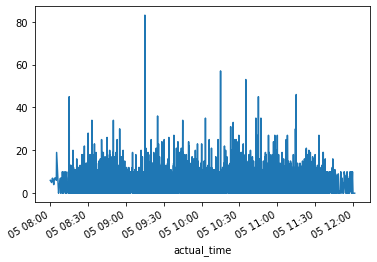

In [26]:
bus_stats.groupby('actual_time').sum().load.plot()